# Lineární klasifikace do více tříd pomocí funkce Softmax

Úloha zaměřená na implementaci paralelního lineární klasifikáru pomocí funkce softmax.


### Softmax
- Funkce softmax má c vstupů a c výstupů. 
- Všechny výstupy jsou kladná čísla. 
- Součet všech výstupů dohromady je roven číslu 1.
$$\widehat{y_c} = softmax(u) = \frac{e^{u_c}}{\sum_{d=0}^{c} {e^{u_d}}} $$

Výsledkem klasifikace je třída, pro kterou je hodnota softmaxu nejvyšší.

### Odhad parametrů modelu

Model nemá jeden vektor parametrů $\theta$, ale matici parametrů $\Theta$

Příklad:
- Vektor $x$ má dimenzi 3 (3 příznaky)
- Klasifikujeme do 4 tříd
$$ \Theta^T = 
        \begin{bmatrix}
        [\theta_{00} & \theta_{01} & \theta_{02} & \theta_{03}] \\
        [\theta_{10} & \theta_{11} & \theta_{12} & \theta_{13}] \\
        [\theta_{20} & \theta_{21} & \theta_{22} & \theta_{23}] \\
        [\theta_{30} & \theta_{31} & \theta_{32} & \theta_{33}] \\
        \end{bmatrix}  $$

#### Pomoc sumy:

$$ \Theta_{t+1} = \Theta_{t} - \alpha \sum_{i=0}^{N} {x_i}^T (\widehat{y_i} - y_i) $$
kde $\alpha$ je velikost kroku (learning rate), 

$y_i$ je vektor, obsahující hodnotu 1 na indexu správné třídy: $y_i \in [...0, 0, 1, 0,..]$,

$\widehat{y_i} = softmax(x_i^T \Theta)^T$


#### Pomocí  matice:
Maticová implementace je řádově výpočetně efektivnější.

$$ \Theta_{t+1} = \Theta_{t} - \alpha X^T (\widehat{Y} - Y) $$
$Y$ je matice nul a jedniček dle indexů tříd v datech (one_hot_encoding), 

#### Postup:
1. Parametr $\theta$ (resp. váhy $w$ a bias $b$) se inicializuje na malé náhodné hodnoty
2. Na vstup se přivedou všechna trénovací data a na výstupu se tím pádem objeví posloupnost nul a jedniček (obsahuje chyby)
3. Na základě chyb se upraví hodnoty vah
4. Kroky 2. a 3. se postupně opakují dokud dostatečně klesá chybovost klasifikátoru (nebo podle počtu iteraci)



### Klasifikace pro 2 třídy:


In [64]:
import numpy as np
import usu
import matplotlib.pyplot as plt

def show_loss(iterations, loss, epoch=False):
    plt.plot(iterations, loss)
    plt.xlabel("Epocha" if epoch else "Iterace")
    plt.ylabel("Loss")
    plt.title("Průběh trénování")
    plt.show()

npzfile = np.load('data/data_07_2cl.npz')

data = npzfile['data']
ref = npzfile['ref']
data.shape, ref.shape



((100, 2), (100, 1))

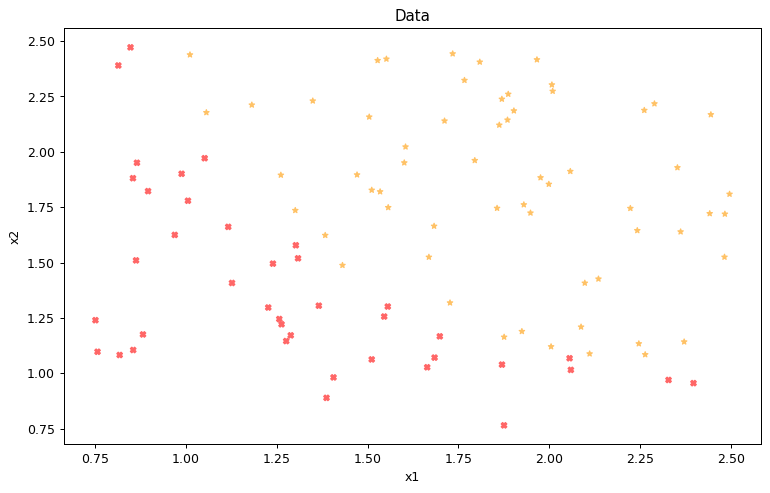

In [65]:
usu.drawSoftmax(data,ref)


In [69]:
def computeThetaGD(x, y, alpha=0.01, iterations=1000, plot_loss=False):
    # pro kazdou iteraci vypoctete loss a zapiste ho na odpovidajici index v promenne
    loss = np.zeros(iterations)

    #################################################################
    # ZDE DOPLNIT

    # Pridani biasu
    ones = np.ones((x.shape[0], 1))
    X = np.hstack((ones, x))
    
    # One-hot encoding
    num_classes = np.max(y) + 1
    Y = np.eye(num_classes)[y]
    
    # Inicializace Theta (nahodna dle zadani)
    theta = np.random.randn(X.shape[1], num_classes) * 0.01
    num_samples = x.shape[0]

    for i in range(iterations):
        scores = X @ theta
        # Softmax aplikujeme po radcich (pro kazdy vzorek zvlast), proto axis=1
        probs = softmax(scores, axis=1)

        # Vypocet loss (Mean Cross Entropy)
        loss[i] = -np.mean(np.sum(Y * np.log(probs + 1e-15), axis=1))

        # Vypocet gradientu
        gradient = X.T @ (probs - Y) / num_samples

        # Update vah
        theta = theta - alpha * gradient

    #################################################################

    if plot_loss:
        show_loss(np.arange(iterations), loss)

    return theta



In [66]:
def softmax(u, axis=0):
    """
    vstupem muze byt skalar, vektor, nebo matice
    """
    #################################################################
    # ZDE DOPLNIT

    u = np.asarray(u)
    is_1d = u.ndim == 1

    if u.ndim == 0:
        return np.array(1.0)

    # Odecteni maxima pro numerickou stabilitu (zabrani preteceni exp)
    u_shifted = u - np.max(u, axis=axis, keepdims=True)
    exp_u = np.exp(u_shifted)
    y = exp_u / np.sum(exp_u, axis=axis, keepdims=True)

    if is_1d:
        return y.flatten()
    #################################################################
    return y

usu.checkSoftmax(softmax)

True

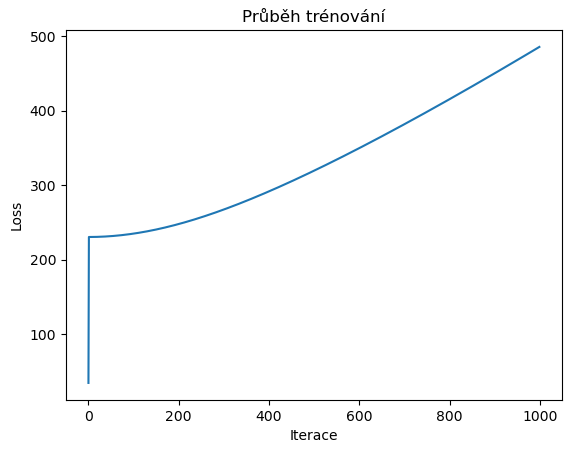

array([[[ 3.94294206, -0.02317223],
        [ 6.47416717, -0.0488582 ],
        [ 6.52103765, -0.06503231]],

       [[ 3.94294206, -0.02317223],
        [ 6.47416717, -0.0488582 ],
        [ 6.52103765, -0.06503231]],

       [[ 3.94294206, -0.02317223],
        [ 6.47416717, -0.0488582 ],
        [ 6.52103765, -0.06503231]],

       [[-0.05705794,  3.97682777],
        [-0.07347369,  6.49891404],
        [-0.08580941,  6.54192618]],

       [[-0.05705794,  3.97682777],
        [-0.07347369,  6.49891404],
        [-0.08580941,  6.54192618]],

       [[ 3.94294206, -0.02317223],
        [ 6.47416717, -0.0488582 ],
        [ 6.52103765, -0.06503231]],

       [[-0.05705794,  3.97682777],
        [-0.07347369,  6.49891404],
        [-0.08580941,  6.54192618]],

       [[-0.05705794,  3.97682777],
        [-0.07347369,  6.49891404],
        [-0.08580941,  6.54192618]],

       [[-0.05705794,  3.97682777],
        [-0.07347369,  6.49891404],
        [-0.08580941,  6.54192618]],

       [[-

In [71]:
theta = computeThetaGD(data, ref, alpha=0.004, plot_loss=True)
theta

ValueError: could not broadcast input array from shape (100,2) into shape (2,)

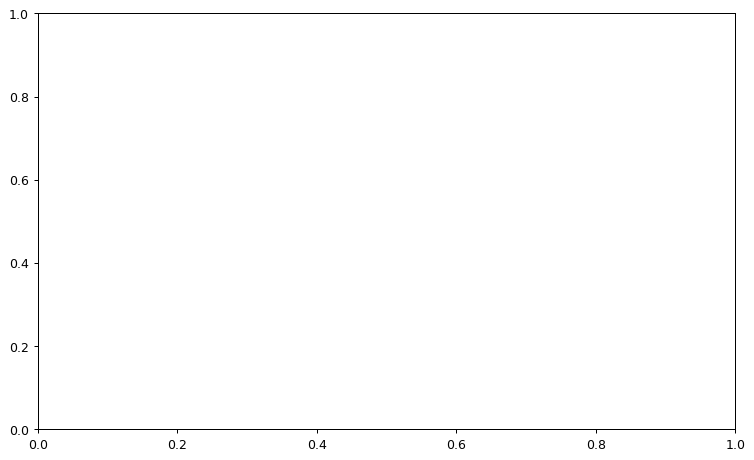

In [60]:
usu.drawSoftmax(data, ref, theta, softmax)


In [8]:
def predict(x,theta):
    #################################################################
    # ZDE DOPLNIT
    # Normalizace dat (pokud jsou v rozsahu 0-255), stejne jako v computeThetaSGD
    if np.max(x) > 10:
        x = x / 255.0

    ones = np.ones((x.shape[0], 1))
    X = np.hstack((ones, x))
    probs = softmax(X @ theta, axis=1)
    classes = np.argmax(probs, axis=1)
    #################################################################
    return classes


In [9]:
x_pred = np.array([[1, 1],[ 2, 2]])
predict(x_pred,theta)


array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0,

### Klasifikace pro více tříd:
#### 3 třídy:


In [10]:
npzfile = np.load('data/data_07_3cl_ez.npz') 

data = npzfile['data']
ref = npzfile['ref']

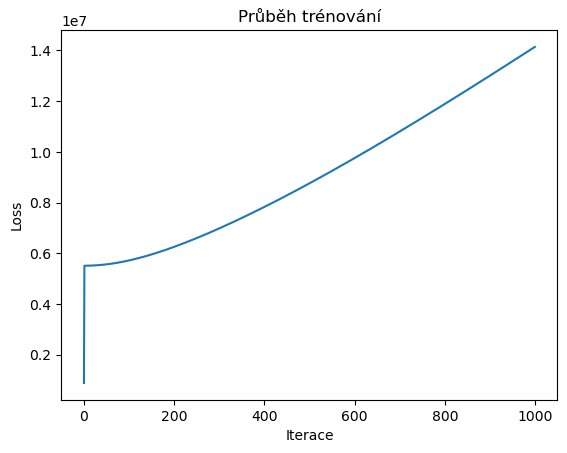

array([[[ 9.99934207e+00, -2.99603708e-02, -1.67011271e-02],
        [ 1.22935850e+00, -9.84315788e-03, -5.68223706e-03],
        [ 3.93586987e+00,  5.38657982e-04,  2.31104330e-03]],

       [[ 9.99934207e+00, -2.99603708e-02, -1.67011271e-02],
        [ 1.22935850e+00, -9.84315788e-03, -5.68223706e-03],
        [ 3.93586987e+00,  5.38657982e-04,  2.31104330e-03]],

       [[ 9.99934207e+00, -2.99603708e-02, -1.67011271e-02],
        [ 1.22935850e+00, -9.84315788e-03, -5.68223706e-03],
        [ 3.93586987e+00,  5.38657982e-04,  2.31104330e-03]],

       ...,

       [[-6.57931265e-04, -2.99603708e-02,  9.98329887e+00],
        [ 6.50715309e-03, -9.84315788e-03,  1.21671079e+00],
        [-2.91843680e-03,  5.38657982e-04,  3.94130922e+00]],

       [[-6.57931265e-04, -2.99603708e-02,  9.98329887e+00],
        [ 6.50715309e-03, -9.84315788e-03,  1.21671079e+00],
        [-2.91843680e-03,  5.38657982e-04,  3.94130922e+00]],

       [[-6.57931265e-04, -2.99603708e-02,  9.98329887e+00],
 

In [11]:
theta = computeThetaGD(data, ref, plot_loss=True)
theta

In [ ]:
usu.drawSoftmax(data, ref, theta, softmax)


In [ ]:
x_pred = np.array([[-3, 1],[ 0, -2],[ 3, 2]])
predict(x_pred,theta)


#### 4 třídy:

In [ ]:
npzfile = np.load('data/data_07_4cl.npz')

data = npzfile['data']
ref = npzfile['ref']


In [ ]:
theta = computeThetaGD(data, ref, plot_loss=True)
theta

In [ ]:
usu.drawSoftmax(data, ref, theta, softmax)


In [ ]:
x_pred = np.array([[-3, -1],[ -3, 2],[ 3, -1],[ 3, 2]])
predict(x_pred,theta)


#### 5 tříd:

In [ ]:
npzfile = np.load('data/data_07_5cl.npz')

data = npzfile['data']
ref = npzfile['ref']


In [ ]:
theta = computeThetaGD(data, ref, plot_loss=True)
theta

In [ ]:
usu.drawSoftmax(data, ref, theta, softmax)


In [ ]:
x_pred = np.array([[-3, -1],[ -3, 2],[ 3, -1],[ 3, 2],[0, 0]])
predict(x_pred,theta)


# BONUS: Rozpoznávání číslovek (MNIST database) a mini-batch gradient descent

### **Dosáhněte accuracy (vypočtené na konci) alespoň 91 %.**

In [ ]:
npzfile = np.load('data/data_07_mnist_train.npz') 

data = npzfile['data']
ref = npzfile['ref']

Prohlédněte si prvních 20 trénovacích vzorků:

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(20):
    # Prevedeni linearizovych dat zpet na 2D matici.
    img = np.reshape(data[i], (28, 28))
    plt.subplot(4, 5, i+1)
    plt.imshow(img, "gray_r")
    plt.title(ref[i])
    plt.axis("off") 
plt.show()

Naimplementuje trénování modelu pomocí mini-batch gradient descent:

Mini-batch gradient descent vzhledem k množství dat zefektivní trénování (model se natrénuje rychleji a lépe zobecňuje).

Vyjděte z předchozí implementace `computeThetaGD` a upravte ji.

Počet iterací (u GD ekvivalentní průchodu všemi testovacími daty) bude nahrazen počtem tzv. epoch.

Jedna epocha probíhá následovně:
- Na začátku se náhodně zamíchají testovací data.
- Všechna testovací data se projdou po mini-batchích, jejichž délka je vždy rovna zadané `batch_size`. Na základě každého mini-batche se aktualizují váhy (u `computeThetaGD` se aktualizovaly váhy na základě všech dat). Pokud by na konci epochy zbyly vzorky, jejichž počet už je menší než `batch_size`, tak se přeskočí.
- Na konci epochy se spočítá loss na základě všech dat pro vizualizaci.

TIP: Vhodně normalizujte úpravu vah, aby její výsledná velikost nezávisela na `batch_size` a parametry `alpha` a `batch_size` jste mohli ladit nezávisle na sobě.

In [ ]:
def computeThetaSGD(x, y, *, alpha, epochs, batch_size, plot_loss=False):
    # zafixovani nahody pri trenovani
    np.random.seed(0)

    # na konci kazde epochy vypoctete loss (ze vsech trenovacich vzorku) a zapiste ho na odpovidajici index v promenne
    loss = np.zeros(epochs)

    #################################################################
    # ZDE DOPLNIT

    # Normalizace dat (pokud jsou v rozsahu 0-255)
    if np.max(x) > 10:
        x = x / 255.0

    # Pridani biasu
    ones = np.ones((x.shape[0], 1))
    X = np.hstack((ones, x))
    
    # One-hot encoding
    num_classes = np.max(y) + 1
    Y = np.eye(num_classes)[y]
    
    # Inicializace Theta
    theta = np.random.randn(X.shape[1], num_classes) * 0.01
    num_samples = X.shape[0]
    
    for epoch in range(epochs):
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        Y_shuffled = Y[indices]
        
        for i in range(0, num_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            Y_batch = Y_shuffled[i:i+batch_size]
            if X_batch.shape[0] < batch_size: continue
            
            probs = softmax(X_batch @ theta, axis=1)
            gradient = (X_batch.T @ (probs - Y_batch)) / batch_size
            theta = theta - alpha * gradient
            
        full_probs = softmax(X @ theta, axis=1)
        loss[epoch] = -np.mean(np.sum(Y * np.log(full_probs + 1e-15), axis=1))
    
    #################################################################

    if plot_loss:
        show_loss(np.arange(epochs), loss, epoch=True)

    return theta


In [ ]:
 # ZDE DOPLNIT hodnoty hyperparametrů (dostatečný model lze natrénovat během 5-10 sekund)
theta = computeThetaSGD(data, ref, batch_size=128, epochs=30, alpha=0.05, plot_loss=True)
#################################################################

theta

Prohlédněte si natrénované váhy (s výjimkou biasu):

In [ ]:
for i in range(theta.shape[1]):
    # Prvni vaha je bias, zbytek odpovida bodum v obrazu, takze je preskupime na 2D obraz.
    img = np.reshape(theta.T[i][1:], (28, 28))
    plt.subplot(2, 5, i+1)
    plt.imshow(img, "gray_r")
    plt.title(str(i))
    plt.axis("off") 
plt.show()

In [ ]:
npzfile = np.load('data/data_07_mnist_test.npz') 

test_data = npzfile['data']
test_ref = npzfile['ref']

Otestujte prvních 20 testovacích vzorků:

In [ ]:
n = 20
x = test_data[:n, :]
y = test_ref[:n]

#################################################################
# ZDE DOPLNIT - Zjistete predikovane tridy pro `x`

y_pred = predict(x, theta)

#################################################################

plt.figure(figsize=(10, 6))
for i in range(n):
    # Prevedeni linearizovych dat zpet na 2D matici.
    img = np.reshape(x[i, :], (28, 28))
    plt.subplot(4, 5, i+1)
    plt.tight_layout(pad=3.0)
    plt.imshow(img, "gray_r")
    plt.title(f"predicted: {y_pred[i]}\nactual: {y[i]}")
    plt.axis("off")
plt.show()

Accuracy – přesnost natrénovaného modelu:

In [ ]:
#################################################################
# ZDE DOPLNIT - Zjistete predikovane tridy pro vsechna testovaci data a procento spravne predikovanych dat (accuracy).

y_test_pred = predict(test_data, theta)
accuracy = np.mean(y_test_pred == test_ref)

#################################################################

print(f"Accuracy: {accuracy * 100}%")

Navíc: všimněte si, jak se mění grafy vah, když zvyšujete/snižujete batch size.